# Higgs-boson kaggle competition
**Работу выполнил**: Радослав Нейчев

**15 мая 2016**

### Преамбула
Полтора года назад проводилось kaggle-соревнование про классификацию распадов частиц.

Страница соревнования: https://www.kaggle.com/c/higgs-boson

### Постановка задачи:
Необходимо построить модель, классифицирующую событие на сигнал (s) и шум (b), а также возвращающую вероятность принадлежности каждому классу. На вход подается размеченная обучающая (training.csv) и контрольная (test.csv) выборки. Для каждого объекта обучающей выборки также известен вес - степень доверия к этому объекту.


### Предобработка данных:
Считаем данные и переобозначим метки классов: обозначим сигнал 1, а шум 0.

In [11]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as mplt
from __future__ import division

In [3]:
def read_data(train_path = 'data/training.csv', test_path = 'data/test.csv'):
    data_train = pd.read_csv(train_path)
    data_test = pd.read_csv(test_path)
    data_train['Label'] = data_train['Label'].map(lambda x: 1 if x == 's' else (0 if x == 'b' else -1))
    return data_train, data_test

data_train, data_test = read_data()

In [8]:
for x in list(data_train.columns):
    tmp = data_train[x].map(lambda  y: None if y == -999.0 else y)
    nan_num = tmp.isnull().sum()
    if (nan_num != 0):
        print(x + ': \t\t' + str(nan_num) +  '\tNA values')

DER_mass_MMC: 		38114	NA values
DER_deltaeta_jet_jet: 		177457	NA values
DER_mass_jet_jet: 		177457	NA values
DER_prodeta_jet_jet: 		177457	NA values
DER_lep_eta_centrality: 		177457	NA values
PRI_jet_leading_pt: 		99913	NA values
PRI_jet_leading_eta: 		99913	NA values
PRI_jet_leading_phi: 		99913	NA values
PRI_jet_subleading_pt: 		177457	NA values
PRI_jet_subleading_eta: 		177457	NA values
PRI_jet_subleading_phi: 		177457	NA values


Значения вышеуказанных признаков имеют большое число пропусков, но исключать их из рассмотрения нецелесообразно: они могут обладать высокой информативностью в случае, если значение определено. 

Произведем визуальный анализ значений признаков: 

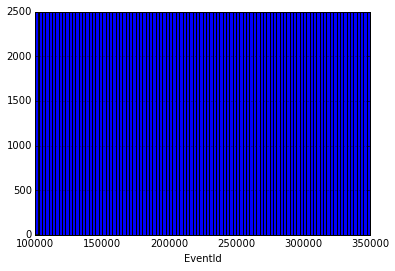

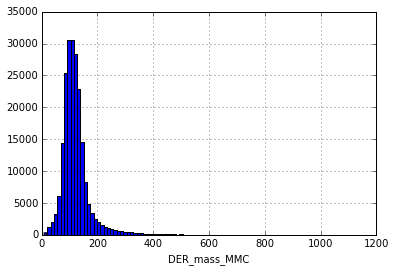

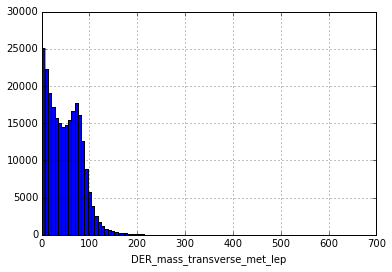

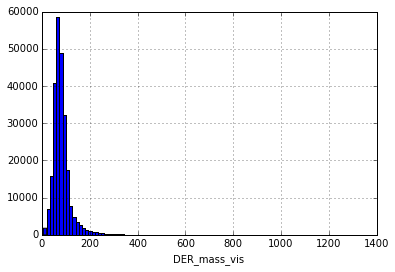

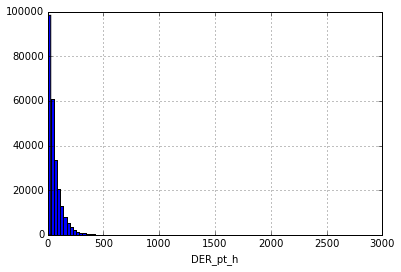

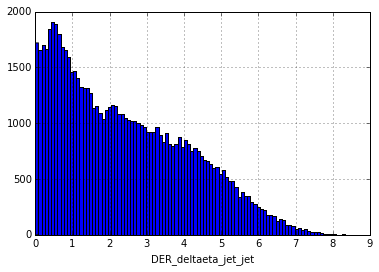

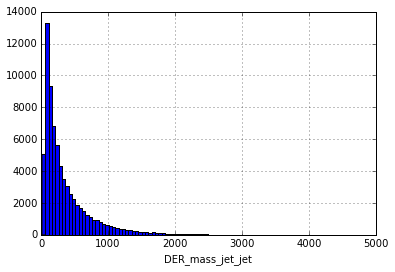

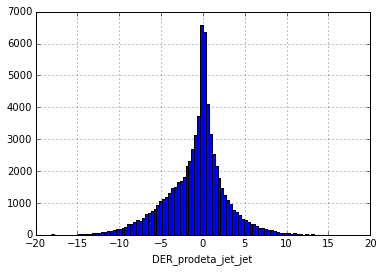

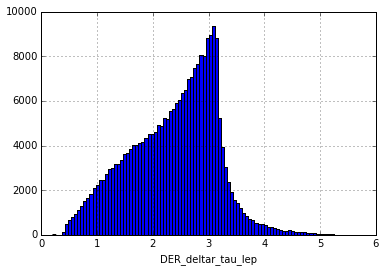

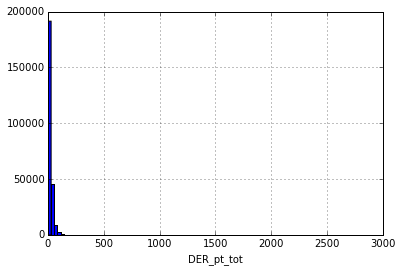

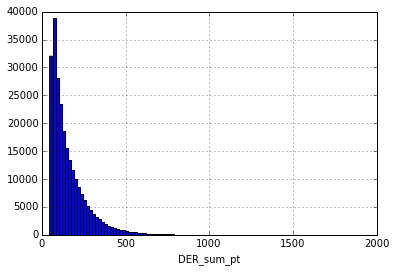

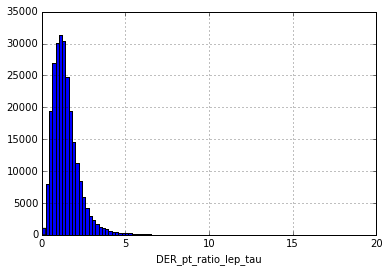

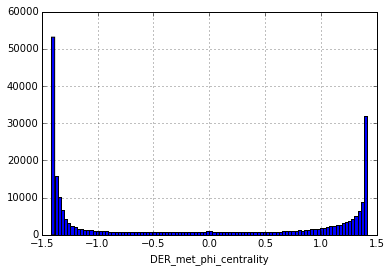

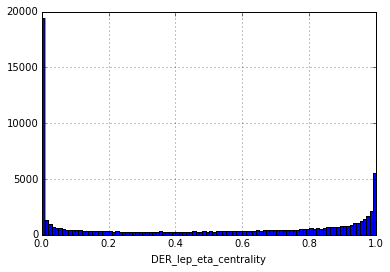

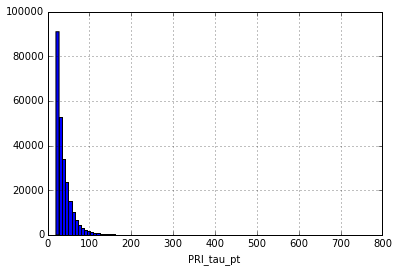

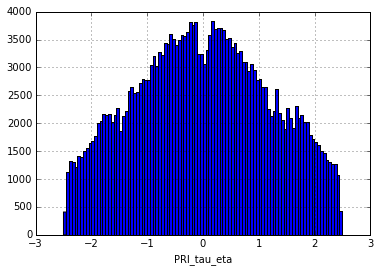

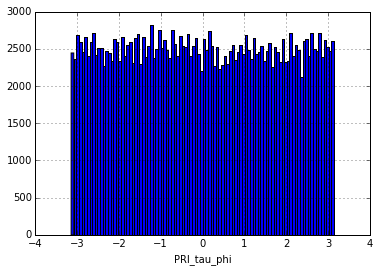

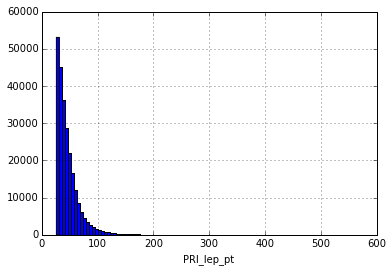

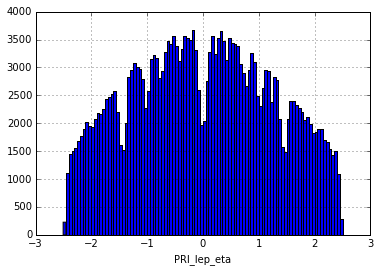

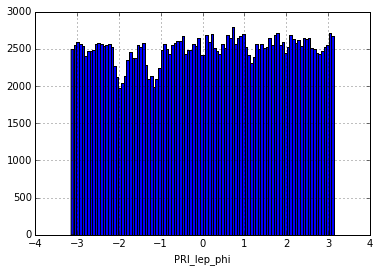

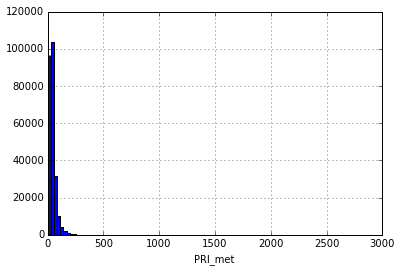

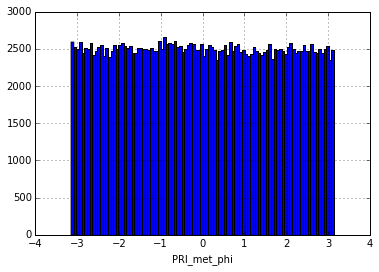

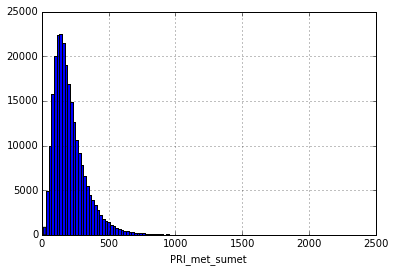

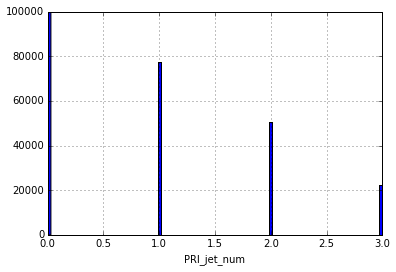

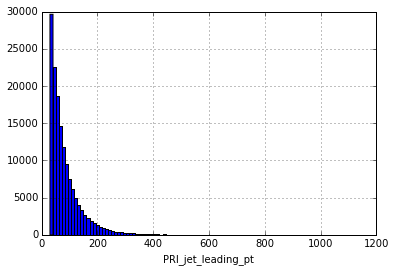

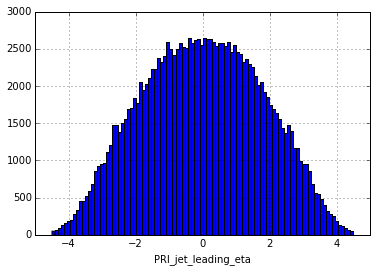

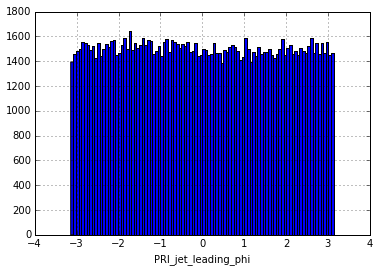

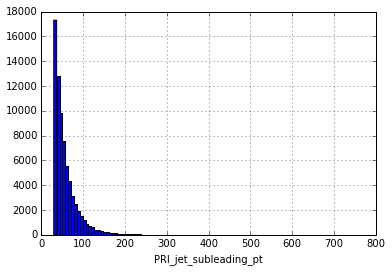

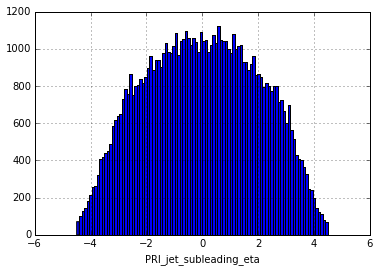

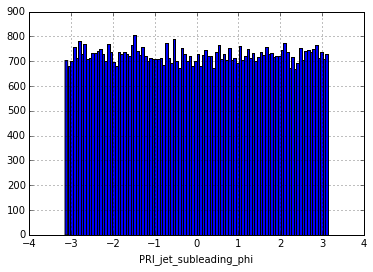

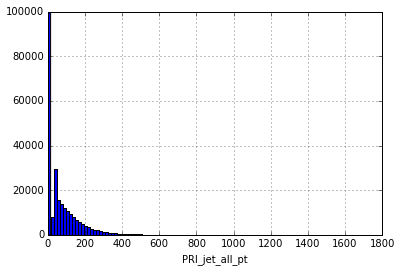

In [15]:
feature_names = list(data_test[1:].columns)
%matplotlib inline
for feature in feature_names:
    tmp = data_train[feature][data_train[feature] != -999.0]
    tmp.hist(bins=100)
    mplt.xlabel(feature)
    mplt.show()

### Решение:
Для решения данной задачи предлагается применить метод градиентного бустинга. В задаче бинарной классификации логично применить решающие деревья, вдобавок, ансамбли деревьев должны быть устойчивы к пропускам в данных, в отличие от линейных моделей. Для решения была использована библиотека XGBoost. Данная реализация хорошо себя зарекомендовала в конкурсах на kaggle, вдобавок  она по умолчанию справляется с пропусками в данных, что избавляет нас от необходимости предобработки данных.

*Примечание: стоило бы сгенерировать новые признаки (коэффициенты корреляции, простейшие функции от значений признаков и др.), так как скорее всего в них содержится дополнительная информация. Эта идея была отложена, а для начала было найдено решение без расширения множества признаков.*

Для определения качества решения используется мера AMS (approximate median significance):
$$ \text{AMS} = \sqrt{2\left((s+b+b_r) \log \left(1 + \frac{s}{b + b_r}\right)-s\right)}, $$ где 
$$ s = \sum_{i=1}^n w_i\mathbb{1}\{y_i = \text{s}\} \mathbb{1}\{\hat{y}_i = \text{s}\}, $$ а
$$ b = \sum_{i=1}^n w_i\mathbb{1}\{y_i = \text{b}\} \mathbb{1}\{\hat{y}_i = \text{s}\} $$  число верных и ошибочных классификаций; $w_i$ - вес (значимость) соотвествующего объекта. За $b_r = 10$ обозначена константа регуляризации.

Разобьем обучающую и тестовую выборки

In [16]:
weights = data_train.Weight.as_matrix()
indexes_train = data_train.EventId.as_matrix()
indexes_test = data_test.EventId.as_matrix()
y_train = data_train.Label.as_matrix()
X_train = data_train.ix[:, 1:-1-1].as_matrix()
X_test =  data_test.ix[:, 1:].as_matrix()

#compute 'scale_posweigth' for xgboost model:
twr = weights[y_train == 1].sum()
fwr = weights[y_train == 0].sum()

Вообще, для подбора некоторых параметров модели (num_rounds, eta, max_depth) было бы логично применить кросс-валидацию, но в ходе изучения возможностей библиотеки XGBoost были обнаружены различные материалы по рассматриваемому конкурсу (приведены в конце работы). Поэтому, для экономии времени, некоторые параметры были позаимствованы из репозиротия автора XGBoost: https://github.com/tqchen/xgboost/tree/master/demo/kaggle-higgs

In [17]:
xgmat = xgb.DMatrix(X_train, label=y_train, missing = -999.0, weight=weights)

#Imported from tqchen git
param = {}
param['objective'] = 'binary:logitraw'
param['scale_pos_weight'] = fwr/twr
param['eta'] = 0.1
param['max_depth'] = 6
param['eval_metric'] = 'ams@0.15'
param['silent'] = 1
plst = list(param.items())

num_rounds = 250
bst = xgb.train(plst, xgmat, num_rounds)
print('Training finished')

Training finished


In [18]:
xgmat_pred = xgb.DMatrix(X_test, missing=-999.0)
y_pred_proba = bst.predict(xgmat_pred)
print('Prediction computed')

Prediction computed


Упорядочим полученные результаты согласно требованиям соревнований сохраним результаты.

In [19]:
threshold_ratio = 0.15
outfile = "results(xgb).csv"

res = [(int(indexes_test[i]), y_pred_proba[i]) for i in range(len(y_pred_proba))]


rorder = {}
rorder_len = 0
for k, v in sorted(res, key = lambda x: x[1], reverse=True):
    rorder[k] = rorder_len + 1
    rorder_len += 1


ntop = int(threshold_ratio * rorder_len)
output = open(outfile, 'w')
nhit = 0
ntot = 0
output.write('EventId,RankOrder,Class\n')
for k, v in res:
    if rorder[k] <= ntop:
        lb = 's'
        nhit += 1
    else:
        lb = 'b'

    output.write('%s,%d,%s\n' % (k,  len(rorder) + 1 - rorder[k], lb))
    ntot += 1
output.close()

Решением было принято тестирующей системой kaggle и показало результат **3.654** (Private score). Ввиду того, что это тестовое задание и в исходных условиях было сказано "Сильно заморачиваться о качестве решения не нужно, достаточно побить результат 3.4 (baseline)", было принято решение отказаться от генерации дополнительных признаков. 

[Скриншот посылки на kaggle](Kaggle_score.png)

Cсылка на профиль: https://www.kaggle.com/neychev

### Список литературы:
[Рассмотрение данной задачи](https://no2147483647.wordpress.com/2014/09/17/winning-solution-of-kaggle-higgs-competition-what-a-single-model-can-do/)

[Библиотека XGBoost](https://github.com/tqchen/xgboost)

[Описание данных и условий эксперимента](Подробное описание данных и эксперимента: https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf)
